In [1]:
!pip uninstall yfinance
!pip uninstall pandas-datareader
!pip install yfinance --upgrade --no-cache-dir
!pip install pandas-datareader

Found existing installation: pandas-datareader 0.9.0
Uninstalling pandas-datareader-0.9.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas_datareader-0.9.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas_datareader/*
Proceed (y/n)? y
  Successfully uninstalled pandas-datareader-0.9.0
     |████████████████████████████████| 6.3 MB 6.1 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 109 kB 5.5 MB/s 


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data

In [42]:
from datetime import date
from dateutil.relativedelta import relativedelta

start = date.today() - relativedelta(years=5)
end   = date.today()

dataframe = data.DataReader('AAPL','yahoo',start,end)
dataframe.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-12,115.000000,112.489998,113.290001,113.300003,26374377.0,110.569847
2016-12-13,115.919998,113.750000,113.839996,115.190002,43733811.0,112.414307
2016-12-14,116.199997,114.980003,115.040001,115.190002,34031834.0,112.414307
2016-12-15,116.730003,115.230003,115.379997,115.820000,46524544.0,113.029099
2016-12-16,116.500000,115.644997,116.470001,115.970001,44351134.0,113.175491


In [43]:
  df = dataframe.reset_index()
  df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-12-12,115.000000,112.489998,113.290001,113.300003,26374377.0,110.569847
1,2016-12-13,115.919998,113.750000,113.839996,115.190002,43733811.0,112.414307
2,2016-12-14,116.199997,114.980003,115.040001,115.190002,34031834.0,112.414307
3,2016-12-15,116.730003,115.230003,115.379997,115.820000,46524544.0,113.029099
4,2016-12-16,116.500000,115.644997,116.470001,115.970001,44351134.0,113.175491
...,...,...,...,...,...,...,...
1254,2021-12-06,167.879898,164.279999,164.289993,165.320007,107496982.0,165.320007
1255,2021-12-07,171.580002,168.339996,169.080002,171.179993,120405352.0,171.179993
1256,2021-12-08,175.960007,170.699997,172.125000,175.080002,116998901.0,175.080002
1257,2021-12-09,176.750000,173.919998,174.910004,174.559998,108157647.0,174.559998


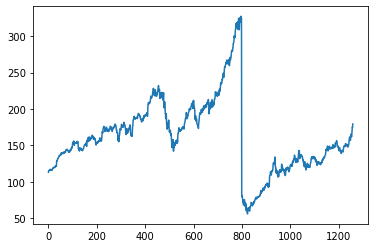

In [44]:
plt.plot(df.Close)

In [45]:
df.shape

(1259, 7)

In [46]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-12-12,115.000000,112.489998,113.290001,113.300003,26374377.0,110.569847
1,2016-12-13,115.919998,113.750000,113.839996,115.190002,43733811.0,112.414307
2,2016-12-14,116.199997,114.980003,115.040001,115.190002,34031834.0,112.414307
3,2016-12-15,116.730003,115.230003,115.379997,115.820000,46524544.0,113.029099
4,2016-12-16,116.500000,115.644997,116.470001,115.970001,44351134.0,113.175491


In [47]:
df = df.drop(['Date','Adj Close'], axis=1)

In [48]:
df.shape

(1259, 5)

In [49]:
train_data = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
test_data = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

print(train_data.shape)
print(test_data.shape)


(881, 1)
(378, 1)


In [50]:
train_data.head()

,Close
0,113.300003
1,115.190002
2,115.190002
3,115.820000
4,115.970001


In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

train_data_array = scaler.fit_transform(train_data)


In [52]:
train_data_array.shape

(881, 1)

In [53]:
X_train = []
y_train = [] 

for i in range(100,train_data_array.shape[0]):
  X_train.append(train_data_array[i-100:i])
  y_train.append(train_data_array[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [54]:
X_train.shape

(781, 100, 1)

In [55]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras import metrics

In [56]:
model=Sequential()
model.add(GRU(512,activation='relu',return_sequences=True,input_shape=(100,1)))
model.add(Dropout(0.2))
model.add(GRU(128,return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 100, 512)          791040    
                                                                 
 dropout_3 (Dropout)         (None, 100, 512)          0         
                                                                 
 gru_4 (GRU)                 (None, 100, 128)          246528    
                                                                 
 dropout_4 (Dropout)         (None, 100, 128)          0         
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [58]:
history = model.fit(X_train,y_train,epochs=10)

Epoch 1/10
25/25 [==============================] - 15s 384ms/step - loss: 0.0350
Epoch 2/10
25/25 [==============================] - 10s 391ms/step - loss: 0.0100
Epoch 3/10
25/25 [==============================] - 10s 387ms/step - loss: 0.0074
Epoch 4/10
25/25 [==============================] - 10s 385ms/step - loss: 0.0064
Epoch 5/10
25/25 [==============================] - 10s 389ms/step - loss: 0.0065
Epoch 6/10
25/25 [==============================] - 10s 395ms/step - loss: 0.0076
Epoch 7/10
25/25 [==============================] - 10s 392ms/step - loss: 0.0061
Epoch 8/10
25/25 [==============================] - 10s 383ms/step - loss: 0.0073
Epoch 9/10
25/25 [==============================] - 10s 387ms/step - loss: 0.0070
Epoch 10/10
25/25 [==============================] - 10s 398ms/step - loss: 0.0056


In [ ]:
model.save('model.h5')

In [59]:
past_100_days = train_data.tail(100)

In [60]:
final_df = past_100_days.append(test_data,ignore_index=True)

In [61]:
final_df

,Close
0,317.700012
1,319.230011
2,318.309998
3,308.950012
4,317.690002
...,...
473,165.320007
474,171.179993
475,175.080002
476,174.559998


In [62]:
input_data = scaler.fit_transform(final_df)
input_data.shape

(478, 1)

In [63]:
X_test = []
y_test = []

for i in range(100, input_data.shape[0]):
  X_test.append(input_data[i-100:i])
  y_test.append(input_data[i,0])



In [64]:
input_data.shape[0]

478

In [65]:
X_test,y_test = np.array(X_test),np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(378, 100, 1)
(378,)


In [66]:
# Making preddiction
# train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [34]:
### Test Data RMSE
# math.sqrt(mean_squared_error(y_test,y_pred))

In [67]:
y_pred.shape

(378, 1)

In [68]:
 scaler.scale_

array([0.00368857])

In [69]:
scale_factor = 1/0.00368857
y_pred = y_pred*scale_factor
y_test = y_test * scale_factor

In [70]:
import sklearn.metrics as metrics

# Caluculate MAE, MSE, RMSE and R2 score
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
r2   = model.evaluate(X_train, y_train)

# print results
print("Results of Model Evaluation: ")
print("\nMean Absolute error (MAE):", mae)
print("\nMean squared error regression loss (MSE):", mse)
print("\nRoot Mean squared error (RMSE):", rmse)
print("\nR^2 Score:", r2)

25/25 [==============================] - 3s 63ms/step - loss: 0.0031
Results of Model Evaluation: 

Mean Absolute error (MAE): 7.401691022906708

Mean squared error regression loss (MSE): 65.01469380724876

Root Mean squared error (RMSE): 8.063168968045304

R^2 Score: 0.003100984962657094


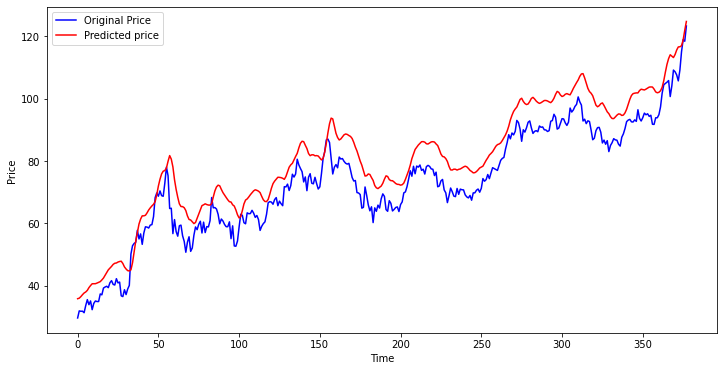

In [71]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'b',label='Original Price')
plt.plot(y_pred,'r',label='Predicted price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()